## Loading Image 

In [2]:
get_ipython().magic('reset -sf') 

In [3]:
# set up notebook to show plots within the notebook
%matplotlib inline

# Import necessary libraries:
# General utilities:
import os
import sys
from time import time

# Computation:
import numpy as np
import h5py
from skimage import measure
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist 

# Visualization:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import display
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import ImageGrid

# Packages for plotting and displaying images/data
from PIL import Image
import spiepy

# Finally, pycroscopy itself
sys.path.append('../../../')
import pycroscopy as px
import pyUSID as usid
import sidpy

# Useful functions
from sidpy.viz.plot_utils import plot_map_stack
usid.plot_utils.use_nice_plot_params()

import warnings
warnings.filterwarnings("ignore")

/Users/sulaymandesai/.pyenv/versions/3.8.3/lib/python3.8/site-packages/pyUSID/viz/__init__.py:16: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  warn('Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. '


In [4]:
# Recording default directory
default_dir = os.getcwd()

# Changing the flat file translator directory
translator_code_dir = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Translator'
os.chdir(translator_code_dir)

# Importing and instantiating flat file translator class
from FlatFileTranslator import FlatFileTranslator
tran = FlatFileTranslator()

In [5]:
os.chdir(default_dir)

In [6]:
FlatFile = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Analysis/prac'
h5USID = '/Users/sulaymandesai/Documents/Year_4/MSciProject/Analysis/h5usid'

In [7]:
h5Path = tran.translate(FlatFile, h5USID)

In [8]:
path = h5Path[1]

In [9]:
h5_file = h5py.File(path, mode='r+')
sidpy.hdf_utils.print_tree(h5_file)

/
├ Measurement_000
  ---------------
  ├ Channel_000
    -----------
    ├ Position_Indices
    ├ Position_Values
    ├ Raw_Data
    ├ Spectroscopic_Indices
    ├ Spectroscopic_Values


In [10]:
# Identifying the main dataset
h5_main = usid.hdf_utils.get_all_main(h5_file)[-1] # Finds all the main data sets. 
print(h5_main)

<HDF5 dataset "Raw_Data": shape (250000, 1), type "<f8">
located at: 
	/Measurement_000/Channel_000/Raw_Data 
Data contains: 
	topo (m) 
Data dimensions and original shape: 
Position Dimensions: 
	Y - size: 500 
	X - size: 500 
Spectroscopic Dimensions: 
	None - size: 1
Data Type:
	float64


In [11]:
# Get the image data as a numpy array
imgArr = h5_main.get_n_dim_form().squeeze()

In [12]:
# Use SPIEpy package to plane subtract the image
imgSub = spiepy.flatten_poly_xy(imgArr, mask=None, deg=1)[0]

# Subtract out the mean of the image
imgSub = imgSub - np.mean(imgSub) 

In [13]:
imgSub_1D = imgSub.reshape((imgSub.shape[0] * imgSub.shape[1], 1))

In [14]:
h5_results_group_1 = h5_file['/Measurement_000/Channel_000']
print(h5_results_group_1)

<HDF5 group "/Measurement_000/Channel_000" (5 members)>


In [15]:
## Once run, comment out to prevent creating new dataset
h5_sub = usid.hdf_utils.write_main_dataset(h5_results_group_1,  # parent group
                                            imgSub_1D,  # data to be written
                                            'Plane_Mean_Subtracted_Data',  # Name of the main dataset
                                            'Plane and mean -Subtracted topo',  # quantity
                                            'm',  # units
                                            None,  # position dimensions
                                            None,  # spectroscopic dimensions
                                            h5_pos_inds=h5_main.h5_pos_inds,
                                            h5_pos_vals=h5_main.h5_pos_vals,
                                            h5_spec_inds=h5_main.h5_spec_inds,
                                            h5_spec_vals=h5_main.h5_spec_vals)

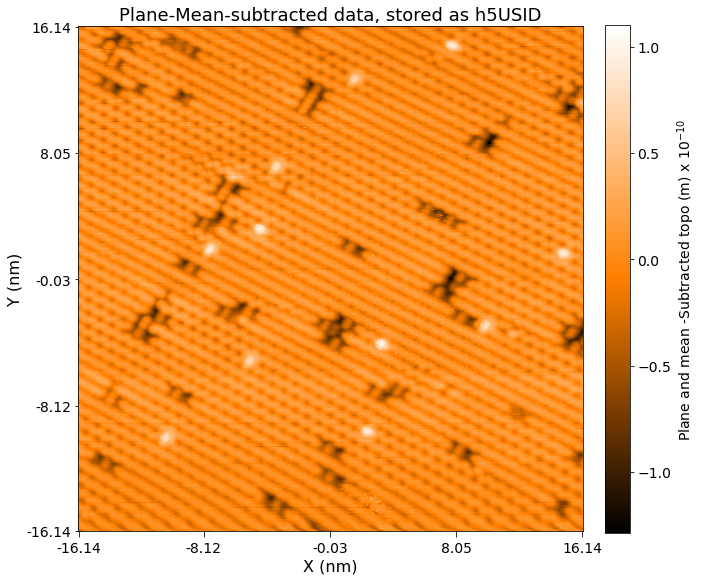

In [16]:
# Get plane and mean subtracted main data
h5Sub_main = usid.hdf_utils.get_all_main(h5_file)[0] 

# Use pyUSID to visualise the image
usid.plot_utils.use_nice_plot_params()
fig, axis = h5Sub_main.visualize(figsize=(10,10), num_ticks=5, cmap = spiepy.NANOMAP)
_ = axis.set_title('Plane-Mean-subtracted data, stored as h5USID', fontsize=18)

In [17]:
iw = px.processing.ImageWindow(h5Sub_main, max_RAM_mb=1024*4)

In [18]:
def __gauss_fit(p, x):
    """
    simple gaussian fitting function
    """
    a = p[0]
    s = p[1]

    g = a * np.exp(-(x / s) ** 2)

    return g

def __gauss_chi(p, x, y):
    """
    Simple chi-squared fit
    """
    gauss = __gauss_fit(p, x)

    chi2 = ((y - gauss) / y) ** 2

    return chi2

In [19]:
h5Main = h5Sub_main.get_n_dim_form().squeeze()

In [20]:
h5Main.shape

(500, 500)

In [21]:
# Normalize the image

immin = np.min(h5Main)
immax = np.max(h5Main)
        
image = np.float32(h5Main - immin) / (immax - immin)

## Performing FFT on image

In signal processing and statistics, a window function (also known as an apodization function or tapering function[1]) is a mathematical function that is zero-valued outside of some chosen interval, normally symmetric around the middle of the interval, usually near a maximum in the middle, and usually tapering away from the middle. Mathematically, when another function or waveform/data-sequence is "multiplied" by a window function, the product is also zero-valued outside the interval: all that is left is the part where they overlap, the "view through the window". Equivalently, and in actual practice, the segment of data within the window is first isolated, and then only that data is multiplied by the window function values. Thus, tapering, not segmentation, is the main purpose of window functions. A hamming window is just a type of multiplication for the isolated data. 

https://en.wikipedia.org/wiki/Window_function

In [22]:
im_shape = np.min(image.shape)

# A hamming filter is a
def __hamming(data):
    """
    Simple hamming filter
    """
    u, v = np.shape(data)
    u_vec = np.linspace(0, 1, u)
    v_vec = np.linspace(0, 1, v)
    u_mat, v_mat = np.meshgrid(u_vec, v_vec, indexing='ij')
    h_filter = np.multiply((1 - np.cos(2 * np.pi * u_mat)), (1 - np.cos(2 * np.pi * v_mat))) / 4.0

    return np.multiply(data, h_filter)

In [23]:
# Centering, subtracting the mean from the image
im2 = image - np.mean(image)

# Computing 2 dimensional discrete fourier transform and shifting so the 0 frequency component is at the centre
fim = np.fft.fftshift(np.fft.fft2(__hamming(im2)))

In [24]:
imrange = np.arange(-im_shape / 2, im_shape / 2)

uu, vv = np.meshgrid(imrange, imrange)

## Finding maximum at each radial distance from the centre

In [25]:
# Why am I dividing by 4
r_n = int(im_shape / 4)

# Specifying the radius of the image?
r_min = 0
r_max = im_shape / 2

# Creating a vector of 125 values till radius of image. Why is it transposed?
r_vec = np.linspace(r_min, r_max, r_n, dtype=np.float32).transpose()

In [26]:
r_mat = np.abs(uu + 1j * vv)

In [27]:
# Getting absolute values of image FFT
fimabs = np.abs(fim)
fimabs_max = np.zeros(r_n - 1)

In [28]:
# Looking for max values along axis. Assuming looking for max intensities / z-heights for where atoms are
for k in range(r_n - 1):
    r1 = r_vec[k]
    r2 = r_vec[k + 1]
    r_ind = np.where(np.logical_and(r_mat >= r1, r_mat <= r2))
    fimabs_max[k] = np.max(fimabs[r_ind])

In [29]:
r_vec = r_vec[:-1] + (r_max - r_min) / (r_n - 1.0) / 2.0

## Finding local maxima

In [30]:
# Finding index for local maxima
# How do these conditions recognise the local maxima
count = 0
local_max = []
for k in range(1, fimabs_max.size - 1):
    if fimabs_max[k - 1] < fimabs_max[k] and fimabs_max[k] > fimabs_max[k + 1]:
        count += 1
        local_max.append(k)

In [31]:
# Getting points correspondong to local maxima
r_loc_max_vec = r_vec[local_max]
fimabs_loc_max_vec = fimabs_max[local_max]

In [32]:
# Removing points below radius of tallest peak 
# Why? What is the tallest peak?

# Index for local fourier maxima
fimabs_loc_max_ind = np.argmax(fimabs_loc_max_vec)

# Retrieving vector for local max
fimabs_loc_max_vec = fimabs_loc_max_vec[fimabs_loc_max_ind:]
r_loc_max_vec = r_loc_max_vec[fimabs_loc_max_ind:]


In [33]:
# Sorting peaks from largest to smallest
sort_ind = np.argsort(fimabs_loc_max_vec)[::-1]
fimabs_sort = fimabs_loc_max_vec[sort_ind]
r_sort = r_loc_max_vec[sort_ind]

In [34]:
# We specify no. of peaks, can guess but skipped out as not using
num_peaks = 2

fimabs_sort = fimabs_sort[:num_peaks]
r_sort = r_sort[:num_peaks]

In [35]:
# Fitting to gaussian

from scipy.optimize import leastsq


# Why do we multiply by 2?
gauss_guess = (2 * np.max(fimabs_sort), r_sort[0])

# least square chi squared fit
fit_vec, pcov, info, errmsg, success = leastsq(__gauss_chi,
                                               gauss_guess,
                                               args=(r_sort, fimabs_sort),
                                               full_output=1,
                                               maxfev=250)

In [36]:
fit_vec

array([3208.62083474,   43.34677505])

In [37]:
# pixel width. Absolute length of image (500), divided by radial distance between atoms and dividing by pi 
psf_width = im_shape / fit_vec[1] / np.pi

In [38]:
# Image window pixel size
window_size = im_shape / (r_sort[0] + 0.5)
window_size

11.403347210224593

In [39]:
# limits the values in array between certain interval
window_size = np.clip(window_size, 1, int(im_shape / 6.0))
window_size

11.403347210224593

In [40]:
window_size = np.int(np.round(window_size * 2))
window_size

23

In [41]:
psf_width

3.6716674513895122

Determining appropriate window size from image.


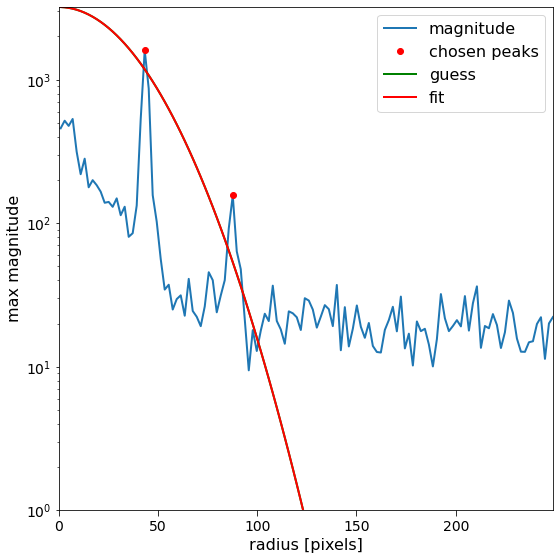

Window size = 23


In [42]:
num_peaks = 2
win_size , psf_width = iw.window_size_extract(num_peaks, save_plots=False, show_plots=True)

print('Window size = {}'.format(win_size))

Both window_size and psf_width determined the same as standard function. 

In [43]:
h5_file.close()